In [2]:
import os 
import keras.backend as K
import numpy as np
from keras.models import save_model, load_model, Model
from keras.layers import Input, Dropout, BatchNormalization, add, Flatten, Dense, Activation
from keras.layers import Conv2D, Conv2DTranspose, Lambda, Reshape, Dot, multiply, LeakyReLU
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
import scipy       #save image
import scipy.io as sio
from keras.engine.topology import Layer
import keras   #optimizer
from keras.optimizers import SGD

Using TensorFlow backend.


In [10]:
train_num = 19   #训练图片数,前train num张
batch_size = 5
input_size_row = 128  #图像大小
input_size_col = 128


filename_X = os.listdir('train&test/train/low_count')   #training data
filename_Y = os.listdir('train&test/train/high_count') #label

filetest_X = os.listdir('train&test/test/low')
filetest_Y = os.listdir('train&test/test/high')

In [8]:
def getdata(filename_X, filename_Y, input_size_row, input_size_col):
    for i in range(len(filename_X)):
        if i == 0:
            img1 = sio.loadmat('train&test/train/low_count/'+filename_X[i])
            img1 = img1['f_EM'].copy()
            img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

            img2 = sio.loadmat('train&test/train/high_count/'+filename_Y[i])
            img2 = img2['f_EM'].copy()
            img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')
            
            img1 = img1/100
            img2 = img2/100
            
            batch_X = img1
            batch_Y = img2
            

        else:
            img1 = sio.loadmat('train&test/train/low_count/'+filename_X[i])
            img1 = img1['f_EM'].copy()
            img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

            img2 = sio.loadmat('train&test/train/high_count/'+filename_Y[i])
            img2 = img2['f_EM'].copy()
            img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')
            
            img1 = img1/100
            img2 = img2/100
            
            batch_X = np.concatenate((batch_X, img1), axis = 0)
            batch_Y = np.concatenate((batch_Y, img2), axis = 0)
            
        
    return  batch_X, batch_Y
    
def get_test_data(filename_X, filename_Y, input_size_row, input_size_col):  #不除200
    for i in range(len(filename_X)):
        if i == 0:
            img1 = sio.loadmat('train&test/test/low/'+filename_X[i])
            img1 = img1['f_EM'].copy()
            img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

            img2 = sio.loadmat('train&test/test/high/'+filename_Y[i])
            img2 = img2['f_EM'].copy()
            img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')

            
            batch_X = img1
            batch_Y = img2
            

        else:
            img1 = sio.loadmat('train&test/test/low/'+filename_X[i])
            img1 = img1['f_EM'].copy()
            img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

            img2 = sio.loadmat('train&test/test/high/'+filename_Y[i])
            img2 = img2['f_EM'].copy()
            img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')
            
            
            batch_X = np.concatenate((batch_X, img1), axis = 0)
            batch_Y = np.concatenate((batch_Y, img2), axis = 0)
            
        
    return  batch_X, batch_Y    
    
def batch_train(train_num, input_size_row, input_size_col, filename_X, filename_Y, batch_size): #原来size 217*181
    rand_num = np.random.choice(train_num)   
    img1 = sio.loadmat('train&test/train/low_count/'+filename_X[rand_num])
    img1 = img1['f_EM'].copy()
    img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

    img2 = sio.loadmat('train&test/train/high_count/'+filename_Y[rand_num])
    img2 = img2['f_EM'].copy()
    img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')
    
    img1 = img1/100
    img2 = img2/100
    
    batch_X = img1
    batch_Y = img2

    for i in range(1, batch_size):
        rand_num = np.random.choice(train_num)    
        img1 = sio.loadmat('train&test/train/low_count/'+filename_X[rand_num])
        img1 = img1['f_EM'].copy()
        img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

        img2 = sio.loadmat('train&test/train/high_count/'+filename_Y[rand_num])
        img2 = img2['f_EM'].copy()
        img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')
        #normalize
        img1 = img1/100
        img2 = img2/100

        batch_X = np.concatenate((batch_X, img1), axis = 0)
        batch_Y = np.concatenate((batch_Y, img2), axis = 0)
        
    return  batch_X, batch_Y

自注意力机制，自己编写的keras版本，网上找到的版本大多不是keras。self attention中的变量gamma是可学习变量，因此需要自定义一层去更新这个变量。

In [4]:
#  SAGAN  x =  gamma * o + x
class Gamma(Layer):

    def __init__(self, **kwargs):
        super(Gamma, self).__init__(**kwargs)

    def build(self, input_shape):

        self._x = K.variable(0.0,name='gamma')
        self.trainable_weights = [self._x]

        super(Gamma, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        O, X = x
        result = self._x*O + X
        return result

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [17]:
# Generator
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1,1), padding='same'):  #BN batchnormalization
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding, activation= 'relu')(x)
#     x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding)(x)
#     x = BatchNormalization(axis=3)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    return x

def Conv2D_BN_down(x, nb_filter, kernel_size, strides=(2,2), padding='same'):  #BN batchnormalization,replace the maxpooling
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding, activation= 'relu')(x)
#     x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding)(x)
#     x = BatchNormalization(axis=3)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    return x

def Conv2dT_BN(x, filters, kernel_size, strides=(2,2), padding='same'):    #up-sampling
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, activation = 'relu')(x)
#     x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
#     x = BatchNormalization(axis=3)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    return x


def hw_flatten(inpt_x):   #长宽reshape
    inpt_x = Reshape([inpt_x.shape[1].value*inpt_x.shape[2].value, inpt_x.shape[3].value])(inpt_x)
    return inpt_x

def self_attention(x, filters, kernel_size = (1,1), strides=(1,1), padding = 'same'):      # x:[bs,H,W,ch]
    f = Conv2D(filters // 8, kernel_size, strides=strides, padding = padding, activation = 'linear')(x) # [bs,H,W,ch/8]
    g = Conv2D(filters // 8, kernel_size, strides=strides, padding = padding, activation = 'linear')(x)
    h = Conv2D(filters, kernel_size, strides=strides, padding = padding, activation = 'linear')(x)      # [bs,H,W,ch]
    
    # [bs,H*W,ch/8]*[bs,H*W,ch/8]_T =>[bs,H*W,H*W]
    s = Dot(axes = -1)([hw_flatten(f), hw_flatten(g)]) 
    
    #softmax
    beta = Lambda(lambda s:K.softmax(s))(s)
    
    # [bs,H*W,H*W]*[bs,H*W,ch]_T =>[bs,H*W,ch]
    o = Dot(axes = 1)([beta, hw_flatten(h)])
    o = Reshape([x.shape[1].value,x.shape[2].value,filters])(o)  #[bs,H,W,ch]
    
    #  x =  gamma * o + x
    x = Gamma()([o, x])
    
    return x

In [18]:
#Generator
#convolution(encoder)
def Generator():

    inpt = Input(shape=(input_size_row, input_size_col, 1))

    conv1 = Conv2d_BN(inpt, 32, (3, 3))
    conv_down1 = Conv2D_BN_down(conv1, 32, (3,3))

    conv2 = Conv2d_BN(conv_down1, 64, (3, 3))
    conv_down2 = Conv2D_BN_down(conv2, 64, (3,3))

    conv3 = Conv2d_BN(conv_down2, 128, (3, 3))
    conv_down3 = Conv2D_BN_down(conv3, 128, (3,3))

    #self-attention
#     SA_layer = conv_down3
    SA_layer = self_attention(conv_down3, 128)


    conv4 = Conv2d_BN(SA_layer, 256, (3, 3))
    conv4 = Dropout(0.5)(conv4)
    conv4 = Conv2d_BN(conv4, 256, (3, 3))
    conv4 = Dropout(0.5)(conv4)


    #transpose convolution(decoder)
    convt1 = Conv2dT_BN(conv4, 128, (3, 3))   #up
    add1 = add([conv3, convt1]) #高度增加     #add
    add1 = Dropout(0.5)(add1)
    conv5 = Conv2d_BN(add1, 128, (3, 3))     #convolution

    convt2 = Conv2dT_BN(conv5, 64, (3, 3))
    add2 = add([conv2, convt2])
    add2 = Dropout(0.5)(add2)
    conv6 = Conv2d_BN(add2, 64, (3, 3))


    convt3 = Conv2dT_BN(conv6, 32, (3, 3))
    add3 = add([conv1, convt3])
    add3 = Dropout(0.5)(add3)
    conv7 = Conv2d_BN(add3, 32, (3, 3))

    conv7 = Conv2d_BN(conv7, 1, (3, 3))
    # conv7 = Dropout(0.5)(conv7)

    outpt = add([conv7, inpt])

    Generator = Model(inpt, outpt,name='Generator')
    # Generator.compile(loss='mse', optimizer='Nadam', metrics=['accuracy'])  #norm_2(G(a)-x)
#     Generator.summary()
    return Generator

In [19]:
# Discriminator
def Discriminator():
    noise_input = Input(shape=(input_size_row, input_size_col, 1))
    D_conv1 =  Conv2d_BN(noise_input, 16, (3, 3))
    D_conv_down1 = Conv2D_BN_down(D_conv1, 32, (3,3))
    D_conv_down2 = Conv2D_BN_down(D_conv_down1, 64, (3,3))

    #self_attenstion
    D_SA_layer = self_attention(D_conv_down2, 64)

    D_conv_down3 = Conv2D_BN_down(D_SA_layer, 128, (3,3))
    D_conv_down4 = Conv2D_BN_down(D_conv_down3, 256, (3,3))
    D_conv2 = Conv2d_BN(D_conv_down4, 4, (3, 3))
#     D_conv2 = Conv2D(4, kernel_size=(3,3), strides=(1,1), padding='same', activation= 'tanh')(D_conv_down4)
    D_conv2 = Dropout(0.4)(D_conv2)
    flatten_x = Flatten()(D_conv2)
    D_output = Dense(1,activation='sigmoid')(flatten_x)

    Discriminator = Model(noise_input, D_output, name='Discriminator')
# discriminator.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

# discriminator_optimizer = keras.optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
# Discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
# Discriminator.summary()
    return Discriminator

In [20]:
#GAN
def SAGAN(G, D):
#     Discriminator.trainable = False
    SAGAN_input = Input(shape=(input_size_row, input_size_col, 1))
    SAGAN_output = D(G(SAGAN_input))
    SAGAN = Model(SAGAN_input, SAGAN_output,name='SAGAN')

#     gan_optimizer = keras.optimizers.RMSprop(lr=4e-4, clipvalue=1.0, decay=1e-8)
#     SAGAN.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
#     SAGAN.summary()
    return SAGAN

In [25]:
###   train_on_batch!!!
if __name__ == "__main__":
    g = Generator()
    d = Discriminator()
    SA_gan = SAGAN(g, d)
    SA_gan.summary()
#     g_opt = keras.optimizers.RMSprop(lr=4e-4, clipvalue=1.0, decay=1e-8)
#     g_opt = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#     g.compile(loss='mse', optimizer='Nadam')
#     g.compile(loss='mse', optimizer=g_opt)
    
    d.trainable = True
    discriminator_optimizer = keras.optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
#     discriminator_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#     discriminator_optimizer = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    d.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
#     d.summary()
    
    d.trainable = False
    gan_optimizer = keras.optimizers.RMSprop(lr=4e-4, clipvalue=1.0, decay=1e-8)
#     gan_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) 
#     gan_optimizer= Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    SA_gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
#     SA_gan.summary()

#     train_X, train_Y = getdata(filename_X, filename_Y, input_size_row, input_size_col)  #所有数据放进去，没有batch
#     train_X, train_Y = batch_train(train_num, input_size_row, input_size_col, filename_X, filename_Y, batch_size)
    real_label = np.ones([batch_size,1])
    fake_label = np.zeros([batch_size,1])
    
#     real_label_2 = np.ones([19,1])
#     fake_label_2 = np.zeros([19,1])
    
    d.trainable = True
#     for i in range(10):
#         loss1 = d.train_on_batch(train_X, fake_label_2)
#         loss2 = d.train_on_batch(train_Y, real_label_2)
    for epoch in range(2):
        
        for batch_index in range(5):
            batch_X, batch_Y = batch_train(train_num, input_size_row, input_size_col, filename_X, filename_Y, batch_size)
            gan_img = g.predict(batch_X)
            
            #critic updates
            for i in range(10):
                loss1 = d.train_on_batch(gan_img, fake_label)
#             for i in range(10):
                loss2 = d.train_on_batch(batch_Y, real_label)

#                 loss3 = d.train_on_batch(batch_X, fake_label)
            print("Epoch", epoch, ": Batch", batch_index, "-",'D_loss_0:',loss1,'D_loss_1:',loss2,'D_loss1+loss2:',loss1+loss2)
#             print('D_loss_3',loss3)
            
            d.trainable = False

            #generator updates
#             for l in range(5):
#                 g_loss = g.train_on_batch(batch_X,batch_Y)
#             print("Epoch", epoch, ": Batch", batch_index, "-",'g_loss',g_loss)
                
            #combine updates
            for j in range(10):
                gan_loss = SA_gan.train_on_batch(batch_X, real_label)
            print("Epoch", epoch, ": Batch", batch_index, "-",'gan_loss',gan_loss)                
            
            print('--------------') 
    
            d.trainable = True 
        print('==============')   
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 128, 128, 1)       0         
_________________________________________________________________
Generator (Model)            (None, 128, 128, 1)       1773666   
_________________________________________________________________
Discriminator (Model)        (None, 1)                 406998    
Total params: 2,180,664
Trainable params: 2,180,664
Non-trainable params: 0
_________________________________________________________________
Epoch 0 : Batch 0 - D_loss_0: 0.6912681 D_loss_1: 0.6078059 D_loss1+loss2: 1.2990739
Epoch 0 : Batch 0 - gan_loss 0.5985757
--------------
Epoch 0 : Batch 1 - D_loss_0: 0.6549211 D_loss_1: 0.43739524 D_loss1+loss2: 1.0923164
Epoch 0 : Batch 1 - gan_loss 0.44793853
--------------
Epoch 0 : Batch 2 - D_loss_0: 0.115687415 D_loss_1: 0.13495311 D_loss1+loss2: 0.2506405
Epoch 0 : Batch 2 - gan_loss

In [12]:
# train_X, train_Y = getdata(filename_X, filename_Y, input_size_row, input_size_col)  #所有数据放进去，没有batch
# # r=d.predict(g.predict(train_X))
# d.trainable = True
# r = SA_gan.predict(train_X)
# SA_gan.summary()
r=d.predict(train_X)
r

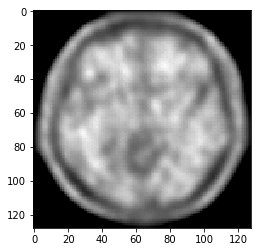

In [44]:
# k = u.predict(train_X)
plt.figure()
plt.imshow(k[11, :, :, 0],plt.cm.gray)    #输出
plt.show()

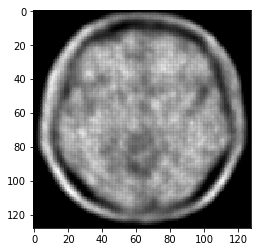

In [13]:
f = g.predict(train_X)
plt.figure()
plt.imshow(f[11, :, :, 0],plt.cm.gray)    #输出
plt.show()

In [1]:
# f = g.predict(train_X)
plt.figure()
plt.imshow(train_Y[4, :, :, 0],plt.cm.gray)    #输出
plt.show()

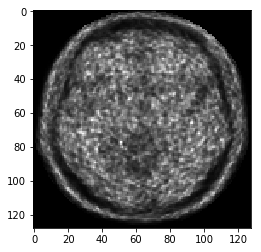

In [42]:
plt.figure()
plt.imshow(train_X[11, :, :, 0],plt.cm.gray)    #输出
plt.show()

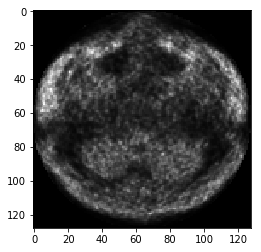

In [70]:
plt.figure()
plt.imshow(train_X[4, :, :, 0],plt.cm.gray)    #输出
plt.show()

In [19]:
f[18, :, :, 0].min()

0.0

In [5]:
#load model
# save_model(g, 'Generator_2.h5')

g = load_model('Generator_2.h5',custom_objects={'Gamma': Gamma()})

# u = load_model('new_unet.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


D:\Applications\Anaconda\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


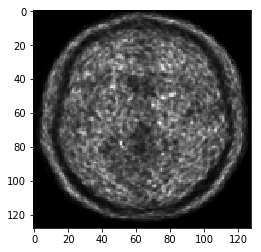

In [73]:
test_X ,test_Y= get_test_data(filetest_X, filetest_Y, input_size_row, input_size_col)
plt.figure()
plt.imshow(test_X[2, :, :, 0],plt.cm.gray)    #输出
plt.show()

In [74]:
pred_Y = g.predict(test_X/100)

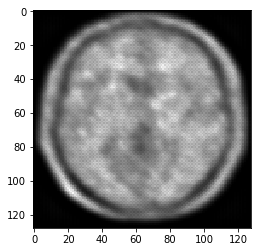

In [81]:
c = pred_Y[2,:,:,0]
# a = np.where(c < 0)
# c[a] = 0
plt.figure()
plt.imshow(c,plt.cm.gray)    #输出
plt.show()

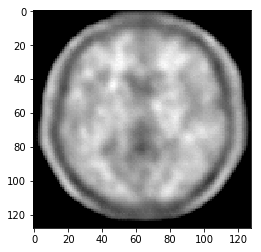

In [23]:
plt.figure()
plt.imshow(pred_Y[2, :, :, 0],plt.cm.gray)    #输出
plt.show()

In [25]:
pred_Y[2, :, :, 0].min()

-0.7959426

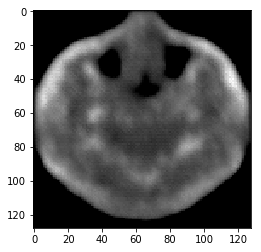

In [24]:
# T_X, T_Y = getdata(filename_X, filename_Y, input_size_row, input_size_col)
# p_Y = model.predict(train_X)
plt.figure()
plt.imshow(p_Y[4, :, :, 0],plt.cm.gray)    #输出
plt.show()

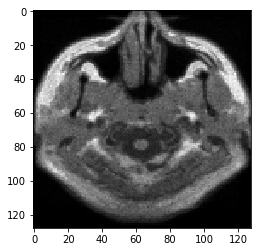

In [12]:
#test
test_filename_X = os.listdir('train&test/test/test_X/')
test_X = io.imread('train&test/test/test_X/'+test_filename_X[0]).astype("float")  #选第0张图片作测试
test_X = resize(test_X, [input_size_row, input_size_col, 1], mode = 'constant')
test_X = np.reshape(test_X,(1, input_size_row, input_size_col, 1))
plt.figure()  #输入
plt.imshow(test_X[0, :, :, 0], plt.cm.gray)
plt.show()
test_X = test_X/255

In [9]:
# 将模型作为一个层，输出第7层的输出
# layer_model = Model(inputs=model.input, outputs=model.layers[0].output)
# feature=layer_model.predict(test_X)
# plt.figure()
# plt.imshow(feature[0, :, :, 0],plt.cm.gray)    #输出
# plt.show()
# a = SA_gan.layers[1]
# # a.layers[35]
# b = Model(a)
# b.summary()
d.trainable = False
a = SA_gan.layers[1]
# layer_1 = K.function([g.get_input_at(0)], [g.get_output_at(0)])
# e = layer_1([train_X])[0]
layer_1 = K.function([SA_gan.input], [a.get_output_at(0)])
e = layer_1([train_X])[0]
g.layers[35].output
a.get_output_at(0)
e.shape

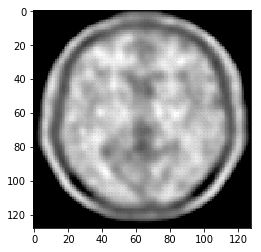

In [49]:
#unet的输出，有一个图像分割的作用
#pred—Y的值有些为负，可能要做变换01之间才能用EM
T_X, T_Y = getdata(filename_X, filename_Y, input_size_row, input_size_col)
pred_Y = model.predict(T_X)
# pred_testY = pred_testY*255
plt.figure()
plt.imshow(pred_Y[13, :, :, 0],plt.cm.gray)    #输出
plt.show()

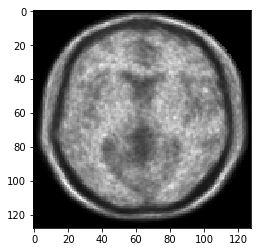

In [106]:
plt.imshow(T_Y[13,:,:,0], plt.cm.gray)
plt.show()

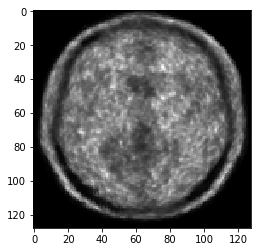

In [103]:
# T_X, T_Y = getdata(filename_X, filename_Y, input_size_row, input_size_col)
# pred_Y = model.predict(T_X)
# pred_testY = pred_testY*255
plt.figure()
plt.imshow(pred_Y[13, :, :, 0],plt.cm.gray)    #输出
plt.show()

In [46]:
scipy.misc.imsave('new_data.jpg', k[4, :, :, 0])

D:\Applications\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
